## Description:

    Use DeSeq2 to identify differential abundance between hybrids
    
    Format table of rhizosphere responders for supplemental
   


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.1’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [6]:
%%R



# Set rep and R_Year as a factor
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$R_Year = factor(sample_data(physeq.Full)$R_Year)

sample_data(physeq.Full)$Plant = factor(sample_data(physeq.Full)$Plant, levels = c("Bare", "322", "330", "339", "354",
                                        "3618", "3517", "3541", "3475", "3394", "34M95", "34N42", "P1151HR"))

#remove BARE soil controls and untreated seeds
phy = subset_samples(physeq.Full, Genotype == "Bare" | SeedTreatment == "Treated")
phy.t1 = subset_samples(phy, TimePoint == "T1")
phy.t2 = subset_samples(phy, TimePoint == "T2")
phy.t3 = subset_samples(phy, TimePoint == "T3")





#re-order levels 
sample_data(phy)$Plant %>% levels


 [1] "Bare"    "322"     "330"     "339"     "354"     "3618"    "3517"   
 [8] "3541"    "3475"    "3394"    "34M95"   "34N42"   "P1151HR"


## Create DeSeq2 object at T1

In [88]:
%%R

diagdds = phyloseq_to_deseq2(phy.t1, ~ Rep + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

In [89]:
%%R
resultsNames(diagdds)

 [1] "Intercept"    "Rep1"         "Rep2"         "Rep3"         "Rep4"        
 [6] "PlantBare"    "Plant330"     "Plant354"     "Plant3517"    "Plant3475"   
[11] "Plant34M95"   "PlantP1151HR"


In [90]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "Bare"), independentFiltering = TRUE, parallel = TRUE, 
                lfcThreshold=1, altHypothesis="greaterAbs")
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [91]:
%%R
Plants = c("330", "354","3517","3475", "34M95","P1151HR")

In [92]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}

In [93]:
%%R
df_plant$TimePoint = "T1"
head(df_plant) %>% print
tail(df_plant) %>% print
df_plant.t1 = df_plant

            baseMean log2FoldChange pvalue padj       OTU Plant TimePoint
OTU.871    8.8536109     0.39821225      1    1   OTU.871   330        T1
OTU.9547   0.3083178     0.32882890      1   NA  OTU.9547   330        T1
OTU.523   16.6672304     0.10839681      1    1   OTU.523   330        T1
OTU.1107   2.3467938     0.08959447      1    1  OTU.1107   330        T1
OTU.11742  1.0199739     0.82236255      1   NA OTU.11742   330        T1
OTU.1889   3.3206802     0.55637617      1    1  OTU.1889   330        T1
           baseMean log2FoldChange pvalue padj      OTU   Plant TimePoint
OTU.55605 0.9295004      0.2386191      1   NA OTU.5560 P1151HR        T1
OTU.23719 0.6829595      0.7173415      1   NA OTU.2371 P1151HR        T1
OTU.30065 0.5974712     -0.1794987      1   NA OTU.3006 P1151HR        T1
OTU.28935 1.1443262      0.8617825      1   NA OTU.2893 P1151HR        T1
OTU.25265 0.6947873      0.4339077      1   NA OTU.2526 P1151HR        T1
OTU.36465 0.4366936      0.5215945    

In [94]:
%%R
range(df_plant$padj, na.rm = TRUE)

[1] 8.863492e-30 1.000000e+00


In [ ]:
## T2

In [95]:
%%R

diagdds = phyloseq_to_deseq2(phy.t2, ~ Rep + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

In [96]:
%%R
resultsNames(diagdds)

 [1] "Intercept"    "Rep1"         "Rep2"         "Rep3"         "Rep4"        
 [6] "PlantBare"    "Plant322"     "Plant330"     "Plant339"     "Plant354"    
[11] "Plant3618"    "Plant3517"    "Plant3541"    "Plant3475"    "Plant3394"   
[16] "Plant34M95"   "Plant34N42"   "PlantP1151HR"


In [97]:
%%R
Plants = sample_data(phy.t2)$Plant %>% levels %>% as.list() %>% .[2:13]
Plants

[[1]]
[1] "322"

[[2]]
[1] "330"

[[3]]
[1] "339"

[[4]]
[1] "354"

[[5]]
[1] "3618"

[[6]]
[1] "3517"

[[7]]
[1] "3541"

[[8]]
[1] "3475"

[[9]]
[1] "3394"

[[10]]
[1] "34M95"

[[11]]
[1] "34N42"

[[12]]
[1] "P1151HR"



In [98]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}


In [99]:
%%R
df_plant$TimePoint = "T2"
head(df_plant) %>% print
tail(df_plant) %>% print
df_plant.t2 = df_plant


            baseMean log2FoldChange pvalue padj       OTU Plant TimePoint
OTU.871    6.7622679     0.57758956      1    1   OTU.871   322        T2
OTU.9547   0.5067196     0.45286261      1   NA  OTU.9547   322        T2
OTU.523   15.6472270     0.40035850      1    1   OTU.523   322        T2
OTU.1107   3.0104143    -0.06386046      1    1  OTU.1107   322        T2
OTU.11742  0.9606480    -0.20274921      1   NA OTU.11742   322        T2
OTU.1889   1.9173930    -0.08656537      1    1  OTU.1889   322        T2
            baseMean log2FoldChange pvalue padj      OTU   Plant TimePoint
OTU.556011 0.6178980      0.1839619      1   NA OTU.5560 P1151HR        T2
OTU.237115 0.5621604      0.2511718      1   NA OTU.2371 P1151HR        T2
OTU.300611 0.1397981     -0.1040683      1   NA OTU.3006 P1151HR        T2
OTU.289311 0.5936930      0.5771136      1   NA OTU.2893 P1151HR        T2
OTU.252611 0.4905315      0.2242125      1   NA OTU.2526 P1151HR        T2
OTU.364611 0.2291424      0.0000

In [ ]:
## T3

In [100]:
%%R

diagdds = phyloseq_to_deseq2(phy.t3, ~ Rep + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

In [101]:
%%R
sample_data(phy.t3)$Plant %>% levels

[1] "Bare"    "330"     "354"     "3517"    "3475"    "34M95"   "P1151HR"


In [102]:
%%R
Plants = sample_data(phy.t3)$Plant %>% levels %>% as.list() %>% .[2:7]
Plants

[[1]]
[1] "330"

[[2]]
[1] "354"

[[3]]
[1] "3517"

[[4]]
[1] "3475"

[[5]]
[1] "34M95"

[[6]]
[1] "P1151HR"



In [103]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}


In [104]:
%%R
df_plant$TimePoint = "T3"
head(df_plant) %>% print
tail(df_plant) %>% print
df_plant.t3 = df_plant


            baseMean log2FoldChange    pvalue padj       OTU Plant TimePoint
OTU.871    7.0889578     0.23372382 1.0000000    1   OTU.871   330        T3
OTU.9547   0.5654895     1.22774221 0.7586021   NA  OTU.9547   330        T3
OTU.523   15.7142936     0.01893640 1.0000000    1   OTU.523   330        T3
OTU.1107   3.1411685    -0.32010874 1.0000000    1  OTU.1107   330        T3
OTU.11742  1.0957710     0.37744915 1.0000000    1 OTU.11742   330        T3
OTU.1889   2.5047068     0.08894006 1.0000000    1  OTU.1889   330        T3
           baseMean log2FoldChange pvalue padj      OTU   Plant TimePoint
OTU.55605 0.9928030      0.4455332      1   NA OTU.5560 P1151HR        T3
OTU.23719 0.6101514      0.5817935      1   NA OTU.2371 P1151HR        T3
OTU.30065 0.2129993      0.1242974      1   NA OTU.3006 P1151HR        T3
OTU.28935 0.4834522      0.4831242      1   NA OTU.2893 P1151HR        T3
OTU.25265 0.4152182     -0.1951405      1   NA OTU.2526 P1151HR        T3
OTU.36465 0.23891

# Join tables

In [112]:
%%R
df_all = rbind(df_plant.t1, df_plant.t2, df_plant.t3)
df_all.fulldeseq = df_all

In [106]:
%%R
df.wide = df_all %>% 
    mutate(PxT = paste(Plant, TimePoint, sep = "_"),
          OTU = row.names(df_all)) %>%
    select(OTU, padj, PxT) %>%
    dcast(OTU ~ PxT, value.var = "padj")

In [107]:
%%R
head(df.wide)

         OTU 322_T2       330_T1 330_T2 330_T3 339_T2 3394_T2 3475_T1 3475_T2
1     OTU.10     NA 1.822177e-28     NA     NA     NA      NA      NA      NA
2    OTU.100     NA 1.000000e+00     NA     NA     NA      NA      NA      NA
3   OTU.1000     NA 1.000000e+00     NA     NA     NA      NA      NA      NA
4  OTU.10001     NA           NA     NA     NA     NA      NA      NA      NA
5 OTU.100010     NA           NA     NA     NA     NA      NA      NA      NA
6 OTU.100011     NA           NA     NA     NA     NA      NA      NA      NA
  3475_T3 34M95_T1 34M95_T2 34M95_T3 34N42_T2 3517_T1 3517_T2 3517_T3 354_T1
1      NA       NA       NA       NA       NA      NA      NA      NA     NA
2      NA       NA       NA       NA       NA      NA      NA      NA     NA
3      NA       NA       NA       NA       NA      NA      NA      NA     NA
4      NA       NA       NA       NA       NA      NA      NA      NA     NA
5      NA       NA       NA       NA       NA      NA      NA      NA

In [108]:
%%R
# Explore rhizosphere responders
sig.up = df_all %>% filter(padj < 0.1 & log2FoldChange > 0)

print(paste("OTUs significantly enriched in the rhizosphere of any genotype: ", 
            sig.up$OTU %>% unique %>% length, sep = ""))

sig.up.t1 = df_all %>% filter(padj < 0.1 & log2FoldChange > 0 & TimePoint == "T1")
print(paste("OTUs significantly enriched in the rhizosphere at T1: ", sig.up.t1$OTU %>% unique %>% length, sep = ""))


sig.up

[1] "OTUs significantly enriched in the rhizosphere of any genotype: 343"
[1] "OTUs significantly enriched in the rhizosphere at T1: 117"
        baseMean log2FoldChange       pvalue         padj       OTU   Plant
1      2.7094469       2.574971 2.085742e-03 6.352364e-02  OTU.1968     330
2     35.9164931       3.418455 3.414181e-07 4.233584e-05   OTU.313     330
3      4.1968931       2.591037 2.615356e-03 7.584185e-02  OTU.1209     330
4      7.1093367       2.357638 2.951684e-03 8.264714e-02   OTU.613     330
5     11.1051888       2.501620 2.936416e-04 1.185492e-02   OTU.844     330
6     21.1695844       2.601621 4.379097e-06 4.001112e-04  OTU.6864     330
7     67.6824845       1.653134 1.809637e-03 5.711874e-02   OTU.621     330
8      9.2008335       1.919633 3.285249e-03 9.052686e-02  OTU.1002     330
9     15.2744522       3.808869 1.422147e-08 2.743164e-06 OTU.12001     330
10     4.1337313       2.167540 1.763697e-03 5.669958e-02 OTU.13201     330
11    10.1684943       2.9

In [109]:
%%R
t.df = tax_table(phy) %>% as.data.frame() %>% mutate(OTU = row.names(.))
left_join(sig.up, t.df, by = "OTU")

        baseMean log2FoldChange       pvalue         padj       OTU   Plant
1      2.7094469       2.574971 2.085742e-03 6.352364e-02  OTU.1968     330
2     35.9164931       3.418455 3.414181e-07 4.233584e-05   OTU.313     330
3      4.1968931       2.591037 2.615356e-03 7.584185e-02  OTU.1209     330
4      7.1093367       2.357638 2.951684e-03 8.264714e-02   OTU.613     330
5     11.1051888       2.501620 2.936416e-04 1.185492e-02   OTU.844     330
6     21.1695844       2.601621 4.379097e-06 4.001112e-04  OTU.6864     330
7     67.6824845       1.653134 1.809637e-03 5.711874e-02   OTU.621     330
8      9.2008335       1.919633 3.285249e-03 9.052686e-02  OTU.1002     330
9     15.2744522       3.808869 1.422147e-08 2.743164e-06 OTU.12001     330
10     4.1337313       2.167540 1.763697e-03 5.669958e-02 OTU.13201     330
11    10.1684943       2.910050 2.379305e-05 1.721031e-03   OTU.546     330
12    77.2284481       5.164303 3.336825e-18 1.448182e-15    OTU.12     330
13    23.857

## Function for generating differential abundance table

In [121]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Plant)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    theta = 1
    r = results(diagdds)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    return(r[, c("log2FoldChange", "p")])
}

get_Psv2 = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Plant)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    #theta = 1
    r = results(diagdds, independentFiltering = TRUE, parallel = TRUE, 
                lfcThreshold=1, altHypothesis="greaterAbs")
#     beta = r$log2FoldChange
#     betaSE = r$lfcSE
#     p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
#    r$p = p
   
    return(r) #[, c("log2FoldChange", "p")])
}

#Function to trim physeq object to just samples to include in Deseq analysis
deseq_prune = function(physeq.obj, plant, day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Plant %in% c("Bare", plant))&
                     (physeq.md$TimePoint == day), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > 0, TRUE)
    return(p.thresh)
}


## Loop through sampling dates and plants to compare to bare soil

In [122]:
%%R
Sd = sample_data(phy) %>% as.data.frame()
days = levels(Sd$TimePoint)

df_all = data.frame()
df_plant = data.frame()

for (day in days) {
    #print(day) ##need to remove
    Sd.d = Sd[Sd$TimePoint == day,]
    Sd.d = Sd.d[Sd.d$Plant != "Bare"]
    Plants = levels(Sd.d$Plant) 
    Plants %>% print

    for (plant in Plants) {
        DF = NULL
        
        #Trim physeq object by to day-plant combo 
        physeq.plant = deseq_prune(phy, plant, day)
        
        #re-order levels 
        sample_data(physeq.plant)$Plant = relevel(sample_data(physeq.plant)$Plant, "Bare")
        
        #convert to deseq using function above
        # using second function to test difference with manual calculations vs internal DESeq calculations
        DF = get_Psv2(physeq.plant)
        
        supp = tax_table(physeq.plant)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  
   
        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$TimePoint = day
        DF$Plant = plant
        df_plant = rbind(df_plant, DF)     
    }

}
df_all = df_plant  


[1] "P1151HR"
[1] "330"     "354"     "3517"    "3475"    "34M95"   "P1151HR"
 [1] "322"     "330"     "339"     "354"     "3618"    "3517"    "3541"   
 [8] "3475"    "3394"    "34M95"   "34N42"   "P1151HR"
[1] "330"     "354"     "3517"    "3475"    "34M95"   "P1151HR"


In [130]:
%%R
BareHybrid = df_all

In [139]:
%%R
BareHybrid$p.adj = p.adjust(BareHybrid$pvalue, "BH")

In [141]:
%%R
# Explore rhizosphere responders after multiple comparison correction across all comps
sig.up = BareHybrid %>% filter(p.adj < 0.05 & log2FoldChange > 0)

print(paste("OTUs significantly enriched in the rhizosphere of any genotype: ", 
            sig.up$OTU %>% unique %>% length, sep = ""))

sig.up.t1 = BareHybrid %>% filter(p.adj < 0.05 & log2FoldChange > 0 & TimePoint == "T1")
print(paste("OTUs significantly enriched in the rhizosphere at T1: ", sig.up.t1$OTU %>% unique %>% length, sep = ""))

sig.up.t2 = BareHybrid %>% filter(p.adj < 0.05 & log2FoldChange > 0 & TimePoint == "T2")
print(paste("OTUs significantly enriched in the rhizosphere at T2: ", sig.up.t2$OTU %>% unique %>% length, sep = ""))

sig.up.t3 = BareHybrid %>% filter(p.adj < 0.05 & log2FoldChange > 0 & TimePoint == "T3")
print(paste("OTUs significantly enriched in the rhizosphere at T3: ", sig.up.t3$OTU %>% unique %>% length, sep = ""))

sig.up.t0 = BareHybrid %>% filter(p.adj < 0.05 & log2FoldChange > 0 & TimePoint == "T0")
print(paste("OTUs significantly enriched in the rhizosphere at T0: ", sig.up.t0$OTU %>% unique %>% length, sep = ""))

#sig.up

[1] "OTUs significantly enriched in the rhizosphere of any genotype: 284"
[1] "OTUs significantly enriched in the rhizosphere at T1: 125"
[1] "OTUs significantly enriched in the rhizosphere at T2: 78"
[1] "OTUs significantly enriched in the rhizosphere at T3: 241"
[1] "OTUs significantly enriched in the rhizosphere at T0: 0"


* Without multiple comparisons across all comps:
    [1] "OTUs significantly enriched in the rhizosphere of any genotype: 352"
    [1] "OTUs significantly enriched in the rhizosphere at T1: 142"
    [1] "OTUs significantly enriched in the rhizosphere at T2: 85"
    [1] "OTUs significantly enriched in the rhizosphere at T3: 304"
    [1] "OTUs significantly enriched in the rhizosphere at T0: 0"

In [132]:
%%R -i workDir


write.csv(BareHybrid, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv", row.names = FALSE, sep = ",")

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown aesthetics: position

  warnings.warn(x, RRuntimeWarning)


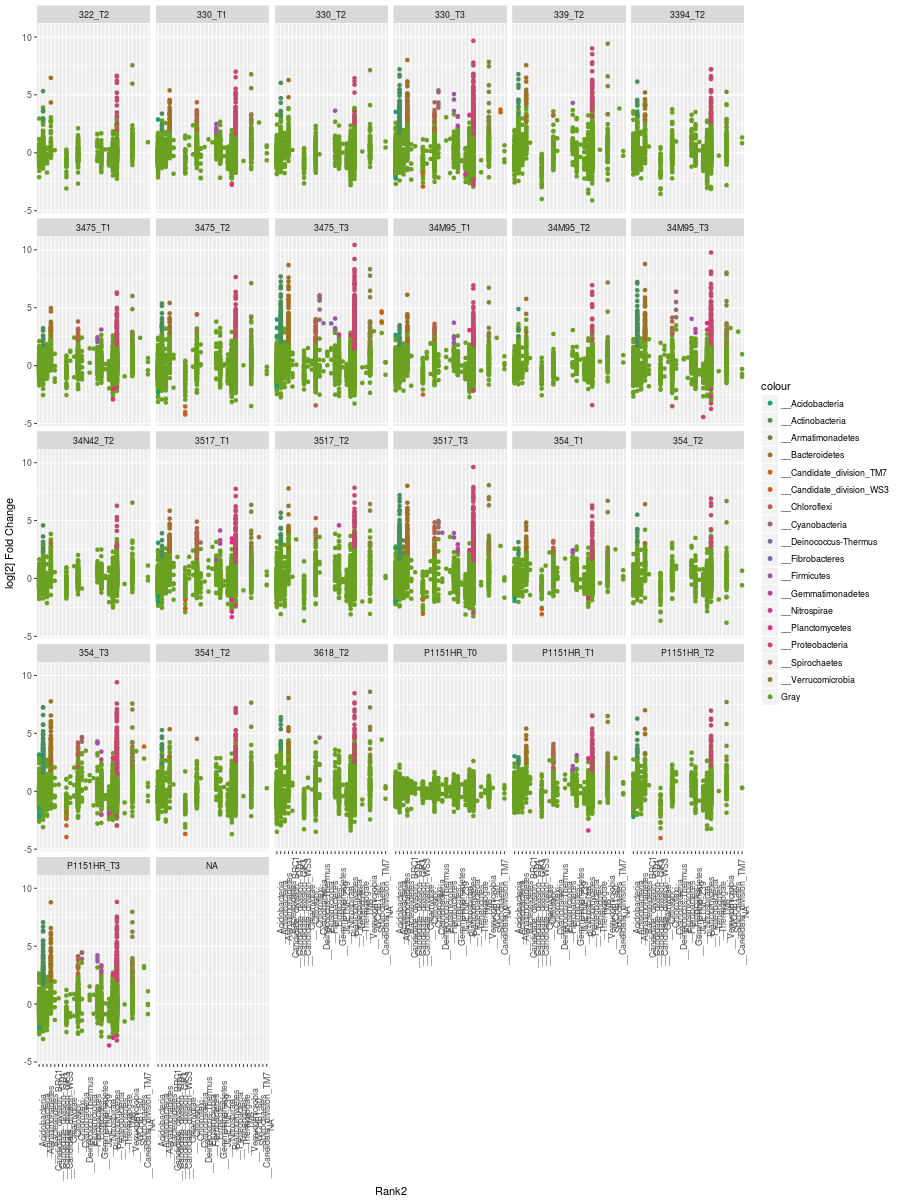

In [133]:
%%R -w 900 -h 1200

df = BareHybrid %>% as.data.frame() %>% mutate(PxT = paste(Plant, TimePoint, sep = "_"))
colourCount = length(unique(df$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

df.adj = df[!is.na(df$padj),]
df.sig = df[df$padj < .1,]
df.ns = df[df$padj >= .1,]

p = ggplot(df)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~PxT)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p    
    

# Global bare vs planted at T2

In [136]:
%%R
sample_data(phy.t2)$Planted = ifelse(sample_data(phy.t2)$Plant == "Bare", "Bare", "Rhizosphere")

In [137]:
%%R
diagdds = phyloseq_to_deseq2(phy.t2, ~Planted)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

    

In [138]:
%%R
r = results(diagdds, independentFiltering = TRUE, parallel = TRUE, 
                lfcThreshold=1, altHypothesis="greaterAbs")

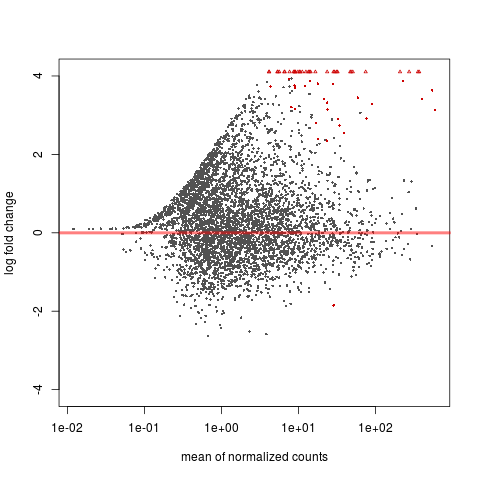

In [142]:
%%R
plotMA(r)

In [146]:
%%R
DF = data.frame(r, as.data.frame(tax_table(phy.t2)))
        DF$OTU = rownames(DF)
        DF$TimePoint ="T2"
        DF$Plant = "All"
sig = DF %>% filter(padj < 0.05 & log2FoldChange > 0)

print(paste("OTUs significantly enriched in the rhizosphere at T2: ", 
            sig$OTU %>% unique %>% length, sep = ""))

[1] "OTUs significantly enriched in the rhizosphere of any genotype: 48"


## Do OTUs enriched in the rhizosphere when comparing individual plants match those in all rhizospehre?

In [148]:
%%R
Indiv = sig.up.t2$OTU %>% unique 
All = sig$OTU %>% unique

sig %>% filter(!OTU %in% Indiv)

  baseMean log2FoldChange     lfcSE     stat      pvalue       padj    Rank1
1 4.160198       4.211738 0.9862689 3.256453 0.001128136 0.03889717 Bacteria
            Rank2        Rank3          Rank4           Rank5         Rank6
1 __Bacteroidetes __Cytophagia __Cytophagales __Cytophagaceae __Flexibacter
            Rank7 Rank8      OTU TimePoint Plant
1 __Bacteroidetes  <NA> OTU.1419        T2   All


* Comparing individual plants produces all the same OTUs as comparing all planted vs four bare soil plots, except a single Flexibacter OTU


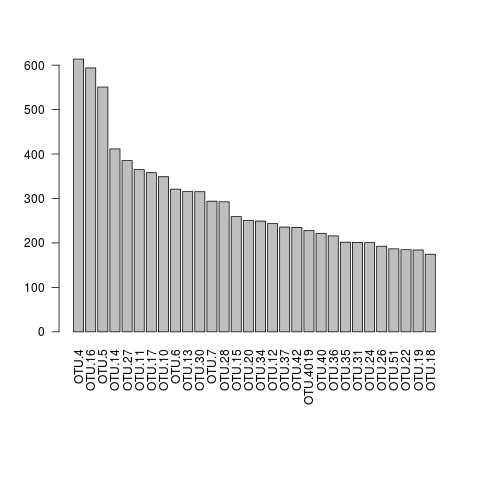

In [60]:
%%R
par(mar = c(10, 4, 4, 2) + 0.1) # make more room on bottom margin
N <- 30
barplot(sort(taxa_sums(phy.t2), TRUE)[1:N]/nsamples(phy.t2), las=2)

In [66]:
%%R
TopNOTUs <- names(sort(taxa_sums(phy.t2), TRUE)[1:25]) 
ent100   <- prune_taxa(TopNOTUs, phy.t2)
print(ent100)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 25 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 25 tips and 24 internal nodes ]


In [ ]:
%%R -w 700 -h 1000
plot_bar(ent100, "X.sampleID", fill="Rank2")+
facet_grid(~Plant, scales = "free_x")